## Setup Environment

In [ ]:
# Install specific libraries
! pip install transformers
! pip install pycaret

In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set Working Directory - if working on Google Drive
%cd /content/drive/MyDrive/D3

# # Set Working Directory - if working on Local Machine
# import os
# os.chdir('/Users//replace_me')

/content/drive/MyDrive/D3


## Load Dataset

Class distribution before balancing:
label
1    7924
0    5528
Name: count, dtype: int64


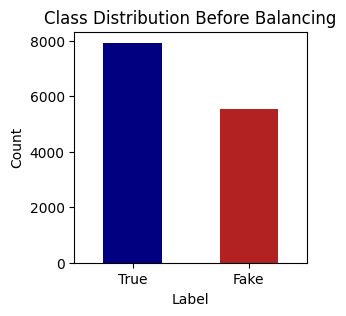

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined data
combined_data_path = '/content/drive/MyDrive/D3/combined_data.csv'
combined_data = pd.read_csv(combined_data_path)

# Check for class imbalance
class_counts = combined_data['label'].value_counts()
print("Class distribution before balancing:")
print(class_counts)

# Plot the class distribution
plt.figure(figsize=(3, 3))
class_counts.plot(kind='bar', color=['navy', 'firebrick'])
plt.title('Class Distribution Before Balancing')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['True', 'Fake'], rotation=0)
plt.show()

Class distribution after balancing:
label
1    7924
0    7924
Name: count, dtype: int64


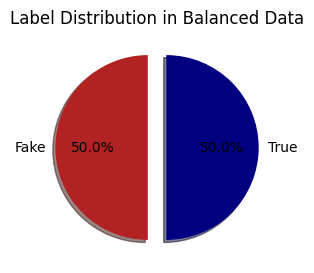

Balanced dataset saved at /content/drive/MyDrive/D3/combined_data_balanced.csv


In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = combined_data[combined_data.label == 1]  # True
df_minority = combined_data[combined_data.label == 0]  # Fake

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,    # sample with replacement
                                 n_samples=len(df_majority),     # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print("Class distribution after balancing:")
print(df_balanced.label.value_counts())

# Save the balanced data
balanced_data_path = '/content/drive/MyDrive/D3/combined_data_balanced.csv'
df_balanced.to_csv(balanced_data_path, index=False)

# Checking if the data is well balanced
label_size = [df_balanced['label'].sum(), len(df_balanced['label']) - df_balanced['label'].sum()]
plt.figure(figsize=(3, 3))
plt.pie(label_size, explode=[0.1, 0.1], colors=['firebrick', 'navy'], startangle=90, shadow=True, labels=['Fake', 'True'], autopct='%1.1f%%')
plt.title('Label Distribution in Balanced Data')
plt.show()

print(f"Balanced dataset saved at {balanced_data_path}")

Balanced Data Shape: (15848, 5)
Balanced Data Head:
      id                                              title        author  \
0  10724  Trumpâs FIRST Order: Anyone Burning An Ameri...  Martin Walsh   
1  19242  WATCH: Gingrich Accuses Megyn Kelly Of Being â...         Davis   
2  11695  Badass Patriot Has MASSIVE Surprise For Thieve...   Amanda Shea   
3   2205  James Wesley Rawles: âDouble Up On Your Prep...     Mac Slavo   
4  14873  Syrian War Report â November 9, 2016: Russia...     The Saker   

                                                text  label  
0  \nPosted by Martin Walsh | Nov 11, 2016 | Libe...      1  
1  Hillary Howls in Laughter About Radical Muslim...      1  
2  Badass Patriot Has MASSIVE Surprise For Thieve...      1  
3  \nEnjoy your turkey, family events and holiday...      1  
4  Leave a Reply Click here to get more info on f...      1  


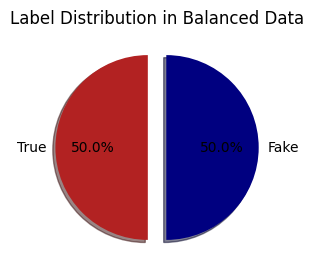

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the balanced data
balanced_data_path = '/content/drive/MyDrive/D3/combined_data_balanced.csv'
balanced_data = pd.read_csv(balanced_data_path)

# Display the shape of the balanced data
print("Balanced Data Shape:", balanced_data.shape)

# Display the head of the balanced data
print("Balanced Data Head:")
print(balanced_data.head())

# Checking if the data is well balanced
label_size = [balanced_data['label'].sum(), len(balanced_data['label']) - balanced_data['label'].sum()]
plt.figure(figsize=(3, 3))
plt.pie(label_size, explode=[0.1, 0.1], colors=['firebrick', 'navy'], startangle=90, shadow=True, labels=['True', 'Fake'], autopct='%1.1f%%')
plt.title('Label Distribution in Balanced Data')
plt.show()

## Train-test-split

In [ ]:
# Train-Temp split (70% train, 30% temp)
train_text, temp_text, train_labels, temp_labels = train_test_split(
    balanced_data['text'], balanced_data['label'],
    random_state=2018, test_size=0.3, stratify=balanced_data['label']
)

# Validation-Test split (15% validation, 15% test from the temp data)
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels,
    random_state=2018, test_size=0.5, stratify=temp_labels
)

# Check the sizes of the splits
print(f'Train set size: {len(train_text)}')
print(f'Validation set size: {len(val_text)}')
print(f'Test set size: {len(test_text)}')

# Optionally, save the splits to CSV files
train_data = pd.DataFrame({'text': train_text, 'label': train_labels})
val_data = pd.DataFrame({'text': val_text, 'label': val_labels})
test_data = pd.DataFrame({'text': test_text, 'label': test_labels})

train_data.to_csv('/content/drive/MyDrive/D3/train_data_split.csv', index=False)
val_data.to_csv('/content/drive/MyDrive/D3/val_data_split.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/D3/test_data_split.csv', index=False)

Train set size: 11093
Validation set size: 2377
Test set size: 2378


## BERT Fine-tuning

### Load pretrained BERT Model

In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Prepare Input Data

Text(0, 0.5, 'Number of texts')

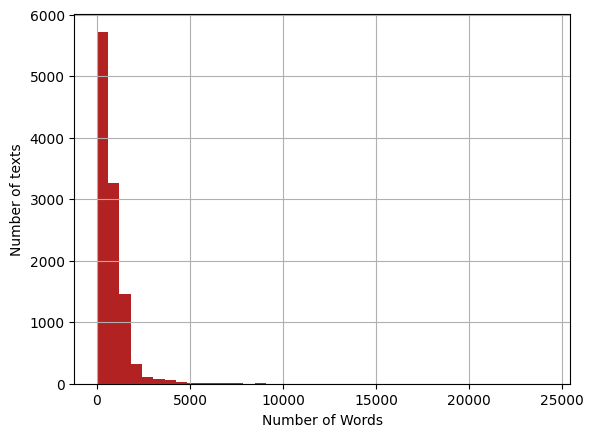

In [ ]:
# Plot histogram of the number of words in train data 'text'
seq_len = [len(text.split()) for text in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.",
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [ ]:
MAX_LENGTH = 512  # Maximum text length

# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)


In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

NameError: name 'train_seq' is not defined

### Freeze Layers

In [ ]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      outputs = self.bert(sent_id, attention_mask=mask)
      cls_hs = outputs.last_hidden_state[:, 0, :]  #
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 5

### Define Train & Evaluate Function

In [ ]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [ ]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels.long())                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(val_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

In [ ]:
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        sent_id, mask, labels = [r.to(device) for r in batch]  # Push the batch to the device (CPU or GPU)
        labels = labels.long()  # Convert labels to Long data type
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss = 0

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        sent_id, mask, labels = [t.to(device) for t in batch]
        labels = labels.long()  # Convert labels to Long data type
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss


### Model training

In [ ]:
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        sent_id, mask, labels = [r.to(device) for r in batch]  # Push the batch to the device (CPU or GPU)
        labels = labels.long()  # Convert labels to Long data type
        model.zero_grad()
        # Make sure the model is on the same device as the data
        model.to(device)  # Move the model to the device
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss = 0

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        sent_id, mask, labels = [t.to(device) for t in batch]
        labels = labels.long()  # Convert labels to Long data type
        with torch.no_grad():
            # Make sure the model is on the same device as the data
            model.to(device)  # Move the model to the device
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

In [ ]:
import torch

# Check if CUDA (GPU) is available
print(torch.cuda.is_available())

True


In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    347.
  Batch   100  of    347.
  Batch   150  of    347.
  Batch   200  of    347.
  Batch   250  of    347.
  Batch   300  of    347.

Evaluating...
  Batch    50  of     75.

Training Loss: 0.639
Validation Loss: 0.569

 Epoch 2 / 5
  Batch    50  of    347.
  Batch   100  of    347.
  Batch   150  of    347.
  Batch   200  of    347.
  Batch   250  of    347.
  Batch   300  of    347.

Evaluating...
  Batch    50  of     75.

Training Loss: 0.549
Validation Loss: 0.482

 Epoch 3 / 5
  Batch    50  of    347.
  Batch   100  of    347.
  Batch   150  of    347.
  Batch   200  of    347.
  Batch   250  of    347.
  Batch   300  of    347.

Evaluating...
  Batch    50  of     75.

Training Loss: 0.480
Validation Loss: 0.424

 Epoch 4 / 5
  Batch    50  of    347.
  Batch   100  of    347.
  Batch   150  of    347.
  Batch   200  of    347.
  Batch   250  of    347.
  Batch   300  of    347.

Evaluating...
  Batch    50  of     75.

Training Loss: 0.432

### Model performance

In [ ]:
import torch
from transformers import BertModel, BertTokenizer
import torch.nn as nn
from torch.utils.data import DataLoader

# Define your BERT-based architecture
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Load the BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')
# Create an instance of your architecture
model = BERT_Arch(bert_model)

# Load weights of the best model
path = 'c1_fakenews_weights.pt'
state_dict = torch.load(path)
# Load the modified state dictionary
model.load_state_dict(state_dict, strict=False)


# Sample test data (replace with your actual test data)
test_seq = torch.randint(0, 30522, (16, 128))  # Example: 16 sequences of length 128 with random token IDs
test_mask = torch.ones(16, 128)  # Example: All tokens are attended to

with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
# Assuming 'test_y' is defined somewhere with your actual test labels
# print(classification_report(test_y, preds))

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

NameError: name 'test_y' is not defined

## Fake News Predictions

In [ ]:
# # load weights of best model
# path = 'c1_fakenews_weights.pt'
# model.load_state_dict(torch.load(path))

In [ ]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

AttributeError: 'SequenceClassifierOutput' object has no attribute 'detach'

In [ ]:
import torch
from transformers import BertForSequenceClassification
import pickle

# Define model name or path
model_name = 'BERT_Arch'

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Define the file path to save the model
model_filepath = "/content/drive/MyDrive/D3/bert_model.pkl"

# Save the model's state dictionary using pickle
with open(model_filepath, 'wb') as f:
    # Save the state dictionary of the model
    pickle.dump(model.state_dict(), f)

# The model's state dictionary is now saved in the specified pickle file

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertForSequenceClassification

# Define the model name or path
model_name = 'bert-base-uncased'

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(model_name)

# Define the directory path to save the model
model_dir = 'bert_model/'

# Save the model's architecture and weights to the specified directory
model.save_pretrained(model_dir)

# The model's architecture and weights are now saved in the specified directory

In [ ]:
from transformers import BertTokenizer

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import pickle
import torch.nn.functional as F

# Define the file path to load the model
model_filepath = "/content/drive/MyDrive/D3/bert_model.pkl"

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Load the model's state dictionary from the pickle file
with open(model_filepath, 'rb') as f:
    state_dict = pickle.load(f)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Put the model in evaluation mode
model.eval()

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a sample input for evaluation
sample_input = "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing"
inputs = tokenizer(sample_input, return_tensors='pt', truncation=True, padding=True)

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# The outputs contain the logits
logits = outputs.logits
print("Logits:", logits)

# Apply softmax to the logits to get probabilities
probabilities = F.softmax(logits, dim=-1)
print("Probabilities:", probabilities)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Logits: tensor([[ 0.6180, -0.0198]])
Probabilities: tensor([[0.6542, 0.3458]])
